In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 92)
(631390, 1)
validation
(74368, 92)
(74368, 1)
test
(85358, 92)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:28 - loss: 0.0334 - STD: 1.4414e-04 - MAE: 0.1656

 7/64 [==>...........................] - ETA: 0s - loss: 0.0214 - STD: 5.0462e-05 - MAE: 0.1136  

12/64 [====>.........................] - ETA: 0s - loss: 0.0175 - STD: 5.8824e-05 - MAE: 0.1013

18/64 [=======>......................] - ETA: 0s - loss: 0.0156 - STD: 7.5409e-05 - MAE: 0.0976

24/64 [==========>...................] - ETA: 0s - loss: 0.0145 - STD: 8.1818e-05 - MAE: 0.0924

30/64 [=============>................] - ETA: 0s - loss: 0.0137 - STD: 9.4695e-05 - MAE: 0.0899

36/64 [===============>..............] - ETA: 0s - loss: 0.0131 - STD: 1.0854e-04 - MAE: 0.0884

41/64 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 1.1815e-04 - MAE: 0.0869

43/64 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 1.2238e-04 - MAE: 0.0864

48/64 [=====================>........] - ETA: 0s - loss: 0.0124 - STD: 1.3513e-04 - MAE: 0.0857

54/64 [========================>.....] - ETA: 0s - loss: 0.0121 - STD: 1.5087e-04 - MAE: 0.0849

60/64 [===========================>..] - ETA: 0s - loss: 0.0119 - STD: 1.6714e-04 - MAE: 0.0842

64/64 [==============================] - 3s 29ms/step - loss: 0.0117 - STD: 1.7978e-04 - MAE: 0.0838 - val_loss: 0.0094 - val_STD: 3.0917e-04 - val_MAE: 0.0770


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0102 - STD: 3.8960e-04 - MAE: 0.0796

 6/64 [=>............................] - ETA: 0s - loss: 0.0100 - STD: 4.0649e-04 - MAE: 0.0780

11/64 [====>.........................] - ETA: 0s - loss: 0.0099 - STD: 4.3259e-04 - MAE: 0.0775

17/64 [======>.......................] - ETA: 0s - loss: 0.0099 - STD: 4.6931e-04 - MAE: 0.0779

23/64 [=========>....................] - ETA: 0s - loss: 0.0099 - STD: 5.0730e-04 - MAE: 0.0778

29/64 [============>.................] - ETA: 0s - loss: 0.0099 - STD: 5.5210e-04 - MAE: 0.0778

34/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 5.9336e-04 - MAE: 0.0778

39/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 6.3972e-04 - MAE: 0.0779

44/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 6.9222e-04 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.5153e-04 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 8.2052e-04 - MAE: 0.0777

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 9.1865e-04 - MAE: 0.0777

64/64 [==============================] - 1s 11ms/step - loss: 0.0098 - STD: 9.9338e-04 - MAE: 0.0776 - val_loss: 0.0092 - val_STD: 0.0019 - val_MAE: 0.0757


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0098 - STD: 0.0023 - MAE: 0.0773

 6/64 [=>............................] - ETA: 0s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0775

11/64 [====>.........................] - ETA: 0s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0772

16/64 [======>.......................] - ETA: 0s - loss: 0.0097 - STD: 0.0032 - MAE: 0.0774

22/64 [=========>....................] - ETA: 0s - loss: 0.0096 - STD: 0.0038 - MAE: 0.0772

28/64 [============>.................] - ETA: 0s - loss: 0.0096 - STD: 0.0045 - MAE: 0.0771

33/64 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 0.0052 - MAE: 0.0769

38/64 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 0.0061 - MAE: 0.0767

43/64 [===================>..........] - ETA: 0s - loss: 0.0094 - STD: 0.0073 - MAE: 0.0764

48/64 [=====================>........] - ETA: 0s - loss: 0.0093 - STD: 0.0087 - MAE: 0.0762

53/64 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.0103 - MAE: 0.0759

59/64 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.0124 - MAE: 0.0756

64/64 [==============================] - 1s 11ms/step - loss: 0.0091 - STD: 0.0142 - MAE: 0.0753 - val_loss: 0.0076 - val_STD: 0.0280 - val_MAE: 0.0679


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0083 - STD: 0.0366 - MAE: 0.0718

 6/64 [=>............................] - ETA: 0s - loss: 0.0081 - STD: 0.0375 - MAE: 0.0708

12/64 [====>.........................] - ETA: 0s - loss: 0.0080 - STD: 0.0383 - MAE: 0.0701

17/64 [======>.......................] - ETA: 0s - loss: 0.0080 - STD: 0.0388 - MAE: 0.0699

23/64 [=========>....................] - ETA: 0s - loss: 0.0079 - STD: 0.0394 - MAE: 0.0696

28/64 [============>.................] - ETA: 0s - loss: 0.0079 - STD: 0.0400 - MAE: 0.0695

34/64 [==============>...............] - ETA: 0s - loss: 0.0079 - STD: 0.0405 - MAE: 0.0692

40/64 [=================>............] - ETA: 0s - loss: 0.0079 - STD: 0.0410 - MAE: 0.0690

45/64 [====================>.........] - ETA: 0s - loss: 0.0079 - STD: 0.0413 - MAE: 0.0688

50/64 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0416 - MAE: 0.0687

56/64 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0419 - MAE: 0.0686

62/64 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0423 - MAE: 0.0685

64/64 [==============================] - 1s 11ms/step - loss: 0.0078 - STD: 0.0424 - MAE: 0.0684 - val_loss: 0.0068 - val_STD: 0.0323 - val_MAE: 0.0613


Epoch 5/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0077 - STD: 0.0449 - MAE: 0.0680

 6/64 [=>............................] - ETA: 0s - loss: 0.0076 - STD: 0.0444 - MAE: 0.0669

12/64 [====>.........................] - ETA: 0s - loss: 0.0077 - STD: 0.0447 - MAE: 0.0670

17/64 [======>.......................] - ETA: 0s - loss: 0.0077 - STD: 0.0451 - MAE: 0.0670

22/64 [=========>....................] - ETA: 0s - loss: 0.0077 - STD: 0.0453 - MAE: 0.0670

28/64 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.0453 - MAE: 0.0670

34/64 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0455 - MAE: 0.0670

39/64 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0456 - MAE: 0.0670

44/64 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.0457 - MAE: 0.0669

50/64 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0457 - MAE: 0.0669

55/64 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0458 - MAE: 0.0669

60/64 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0459 - MAE: 0.0669

64/64 [==============================] - 1s 11ms/step - loss: 0.0076 - STD: 0.0459 - MAE: 0.0668 - val_loss: 0.0068 - val_STD: 0.0338 - val_MAE: 0.0603


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0076 - STD: 0.0461 - MAE: 0.0662

 6/64 [=>............................] - ETA: 0s - loss: 0.0075 - STD: 0.0465 - MAE: 0.0664

11/64 [====>.........................] - ETA: 0s - loss: 0.0075 - STD: 0.0465 - MAE: 0.0663

16/64 [======>.......................] - ETA: 0s - loss: 0.0075 - STD: 0.0468 - MAE: 0.0663

22/64 [=========>....................] - ETA: 0s - loss: 0.0076 - STD: 0.0470 - MAE: 0.0664

27/64 [===========>..................] - ETA: 0s - loss: 0.0075 - STD: 0.0469 - MAE: 0.0663

32/64 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0469 - MAE: 0.0662

37/64 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.0470 - MAE: 0.0663

43/64 [===================>..........] - ETA: 0s - loss: 0.0075 - STD: 0.0472 - MAE: 0.0662

49/64 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0472 - MAE: 0.0662

55/64 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0473 - MAE: 0.0661

60/64 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0473 - MAE: 0.0661

64/64 [==============================] - 1s 11ms/step - loss: 0.0075 - STD: 0.0474 - MAE: 0.0661 - val_loss: 0.0068 - val_STD: 0.0346 - val_MAE: 0.0594


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0074 - STD: 0.0481 - MAE: 0.0647

 6/64 [=>............................] - ETA: 0s - loss: 0.0075 - STD: 0.0488 - MAE: 0.0656

11/64 [====>.........................] - ETA: 0s - loss: 0.0074 - STD: 0.0487 - MAE: 0.0656

16/64 [======>.......................] - ETA: 0s - loss: 0.0075 - STD: 0.0484 - MAE: 0.0657

22/64 [=========>....................] - ETA: 0s - loss: 0.0074 - STD: 0.0482 - MAE: 0.0656

27/64 [===========>..................] - ETA: 0s - loss: 0.0074 - STD: 0.0483 - MAE: 0.0656

33/64 [==============>...............] - ETA: 0s - loss: 0.0074 - STD: 0.0483 - MAE: 0.0655

38/64 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0484 - MAE: 0.0655

43/64 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0485 - MAE: 0.0654

49/64 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0485 - MAE: 0.0653

54/64 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0485 - MAE: 0.0653

60/64 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0486 - MAE: 0.0652

64/64 [==============================] - 1s 11ms/step - loss: 0.0074 - STD: 0.0487 - MAE: 0.0651 - val_loss: 0.0062 - val_STD: 0.0367 - val_MAE: 0.0582


Epoch 8/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0074 - STD: 0.0508 - MAE: 0.0660

 6/64 [=>............................] - ETA: 0s - loss: 0.0072 - STD: 0.0494 - MAE: 0.0639

11/64 [====>.........................] - ETA: 0s - loss: 0.0072 - STD: 0.0495 - MAE: 0.0640

16/64 [======>.......................] - ETA: 0s - loss: 0.0072 - STD: 0.0498 - MAE: 0.0641

21/64 [========>.....................] - ETA: 0s - loss: 0.0072 - STD: 0.0498 - MAE: 0.0640

27/64 [===========>..................] - ETA: 0s - loss: 0.0072 - STD: 0.0496 - MAE: 0.0640

33/64 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0497 - MAE: 0.0639

38/64 [================>.............] - ETA: 0s - loss: 0.0071 - STD: 0.0498 - MAE: 0.0638

43/64 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0499 - MAE: 0.0639

49/64 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0500 - MAE: 0.0637

54/64 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0501 - MAE: 0.0636

60/64 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0503 - MAE: 0.0636

64/64 [==============================] - 1s 11ms/step - loss: 0.0071 - STD: 0.0503 - MAE: 0.0636 - val_loss: 0.0058 - val_STD: 0.0406 - val_MAE: 0.0568


Epoch 9/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0533 - MAE: 0.0642

 7/64 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0519 - MAE: 0.0632

13/64 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0524 - MAE: 0.0627

18/64 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0526 - MAE: 0.0627

23/64 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0526 - MAE: 0.0625

29/64 [============>.................] - ETA: 0s - loss: 0.0070 - STD: 0.0527 - MAE: 0.0628

35/64 [===============>..............] - ETA: 0s - loss: 0.0070 - STD: 0.0527 - MAE: 0.0628

41/64 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.0527 - MAE: 0.0628

46/64 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0526 - MAE: 0.0628

52/64 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0526 - MAE: 0.0627

57/64 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0527 - MAE: 0.0627

63/64 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0528 - MAE: 0.0626

64/64 [==============================] - 1s 11ms/step - loss: 0.0069 - STD: 0.0528 - MAE: 0.0626 - val_loss: 0.0060 - val_STD: 0.0409 - val_MAE: 0.0557


Epoch 10/10000


 1/64 [..............................] - ETA: 0s - loss: 0.0066 - STD: 0.0542 - MAE: 0.0608

 6/64 [=>............................] - ETA: 0s - loss: 0.0068 - STD: 0.0545 - MAE: 0.0617

11/64 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0544 - MAE: 0.0618

16/64 [======>.......................] - ETA: 0s - loss: 0.0068 - STD: 0.0544 - MAE: 0.0615

21/64 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0616

27/64 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0548 - MAE: 0.0615

32/64 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0549 - MAE: 0.0616

38/64 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0550 - MAE: 0.0615

43/64 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0551 - MAE: 0.0615

48/64 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0551 - MAE: 0.0616

53/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0551 - MAE: 0.0616

58/64 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0551 - MAE: 0.0615

64/64 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0552 - MAE: 0.0615

64/64 [==============================] - 1s 11ms/step - loss: 0.0067 - STD: 0.0552 - MAE: 0.0615 - val_loss: 0.0056 - val_STD: 0.0448 - val_MAE: 0.0553


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0569 - MAE: 0.0618

 6/64 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0555 - MAE: 0.0615

11/64 [====>.........................] - ETA: 0s - loss: 0.0067 - STD: 0.0556 - MAE: 0.0614

16/64 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0559 - MAE: 0.0615

21/64 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0561 - MAE: 0.0616

26/64 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0561 - MAE: 0.0615

31/64 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0560 - MAE: 0.0614

37/64 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0561 - MAE: 0.0613

42/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0561 - MAE: 0.0613

47/64 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0561 - MAE: 0.0612

53/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0562 - MAE: 0.0613

59/64 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0562 - MAE: 0.0613

64/64 [==============================] - 1s 11ms/step - loss: 0.0067 - STD: 0.0562 - MAE: 0.0612 - val_loss: 0.0057 - val_STD: 0.0450 - val_MAE: 0.0550


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0568 - MAE: 0.0621

 7/64 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0560 - MAE: 0.0610

13/64 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0562 - MAE: 0.0612

19/64 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0564 - MAE: 0.0612

24/64 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0564 - MAE: 0.0612

30/64 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0566 - MAE: 0.0613

35/64 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0566 - MAE: 0.0612

41/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0567 - MAE: 0.0611

46/64 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0568 - MAE: 0.0611

52/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0568 - MAE: 0.0610

57/64 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0567 - MAE: 0.0610

63/64 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0568 - MAE: 0.0611

64/64 [==============================] - 1s 11ms/step - loss: 0.0067 - STD: 0.0568 - MAE: 0.0611 - val_loss: 0.0067 - val_STD: 0.0405 - val_MAE: 0.0572


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0515 - MAE: 0.0592

 6/64 [=>............................] - ETA: 0s - loss: 0.0069 - STD: 0.0553 - MAE: 0.0616

11/64 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0560 - MAE: 0.0617

16/64 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0558 - MAE: 0.0614

21/64 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0558 - MAE: 0.0614

27/64 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0561 - MAE: 0.0614

33/64 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0562 - MAE: 0.0615

39/64 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0562 - MAE: 0.0617

44/64 [===================>..........] - ETA: 0s - loss: 0.0069 - STD: 0.0557 - MAE: 0.0620

49/64 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0555 - MAE: 0.0623

55/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0550 - MAE: 0.0623

60/64 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0547 - MAE: 0.0623

64/64 [==============================] - 1s 11ms/step - loss: 0.0069 - STD: 0.0546 - MAE: 0.0623 - val_loss: 0.0056 - val_STD: 0.0445 - val_MAE: 0.0573


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0069 - STD: 0.0571 - MAE: 0.0650

 6/64 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0541 - MAE: 0.0619

12/64 [====>.........................] - ETA: 0s - loss: 0.0067 - STD: 0.0537 - MAE: 0.0614

18/64 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0543 - MAE: 0.0614

23/64 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0545 - MAE: 0.0613

28/64 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0548 - MAE: 0.0612

34/64 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0552 - MAE: 0.0612

40/64 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0553 - MAE: 0.0612

46/64 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0554 - MAE: 0.0612

51/64 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0556 - MAE: 0.0612

56/64 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0557 - MAE: 0.0611

62/64 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0558 - MAE: 0.0611

64/64 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0559 - MAE: 0.0610 - val_loss: 0.0057 - val_STD: 0.0447 - val_MAE: 0.0549


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0562 - MAE: 0.0607

 6/64 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0565 - MAE: 0.0608

12/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0565 - MAE: 0.0607

18/64 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0568 - MAE: 0.0607

24/64 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0570 - MAE: 0.0607

30/64 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0571 - MAE: 0.0607

36/64 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0573 - MAE: 0.0607

41/64 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0573 - MAE: 0.0607

47/64 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0574 - MAE: 0.0607

52/64 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0574 - MAE: 0.0607

58/64 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0574 - MAE: 0.0607

64/64 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0575 - MAE: 0.0607

64/64 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0575 - MAE: 0.0607 - val_loss: 0.0057 - val_STD: 0.0455 - val_MAE: 0.0549


Epoch 16/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0570 - MAE: 0.0605

 6/64 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0574 - MAE: 0.0604

12/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0575 - MAE: 0.0604

18/64 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0575 - MAE: 0.0604

24/64 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0576 - MAE: 0.0605

29/64 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0575 - MAE: 0.0605

35/64 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0575 - MAE: 0.0605

40/64 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0576 - MAE: 0.0605

46/64 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0605

51/64 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0605

56/64 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0605

62/64 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0605

64/64 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0578 - MAE: 0.0605 - val_loss: 0.0055 - val_STD: 0.0476 - val_MAE: 0.0549


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0597 - MAE: 0.0621

 6/64 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0582 - MAE: 0.0608

11/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0581 - MAE: 0.0606

16/64 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0604

21/64 [========>.....................] - ETA: 0s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0605

26/64 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0605

31/64 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0605

36/64 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0607

41/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0578 - MAE: 0.0611

47/64 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0572 - MAE: 0.0616

52/64 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0567 - MAE: 0.0617

57/64 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0561 - MAE: 0.0617

62/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0557 - MAE: 0.0617

64/64 [==============================] - 1s 11ms/step - loss: 0.0068 - STD: 0.0557 - MAE: 0.0617 - val_loss: 0.0061 - val_STD: 0.0396 - val_MAE: 0.0559


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0517 - MAE: 0.0600

 6/64 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0542 - MAE: 0.0607

11/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0554 - MAE: 0.0608

16/64 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0559 - MAE: 0.0606

22/64 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0561 - MAE: 0.0606

27/64 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0564 - MAE: 0.0606

33/64 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0565 - MAE: 0.0607

39/64 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0565 - MAE: 0.0607

44/64 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0566 - MAE: 0.0607

50/64 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0566 - MAE: 0.0606

55/64 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0568 - MAE: 0.0607

61/64 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0568 - MAE: 0.0607

64/64 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0569 - MAE: 0.0607 - val_loss: 0.0057 - val_STD: 0.0457 - val_MAE: 0.0549


Epoch 19/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0576 - MAE: 0.0591

 6/64 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0602

11/64 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0604

17/64 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0604

22/64 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0604

27/64 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0605

32/64 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0605

38/64 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0579 - MAE: 0.0606

44/64 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0606

49/64 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0606

54/64 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0579 - MAE: 0.0606

59/64 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0579 - MAE: 0.0606

64/64 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0605

64/64 [==============================] - 1s 11ms/step - loss: 0.0065 - STD: 0.0578 - MAE: 0.0605 - val_loss: 0.0057 - val_STD: 0.0460 - val_MAE: 0.0547


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0570 - MAE: 0.0603

 7/64 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0577 - MAE: 0.0605

12/64 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0605

17/64 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0604

23/64 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0604

28/64 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0604

33/64 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0604

38/64 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0605

44/64 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0605

49/64 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0605

55/64 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0577 - MAE: 0.0605

60/64 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0605

64/64 [==============================] - 1s 11ms/step - loss: 0.0065 - STD: 0.0578 - MAE: 0.0605 - val_loss: 0.0056 - val_STD: 0.0463 - val_MAE: 0.0548


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0063 - STD: 0.0582 - MAE: 0.0601

 6/64 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0607

11/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0580 - MAE: 0.0607

16/64 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0581 - MAE: 0.0605

22/64 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0581 - MAE: 0.0604

28/64 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0581 - MAE: 0.0604

34/64 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0582 - MAE: 0.0603

39/64 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0582 - MAE: 0.0603

45/64 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0581 - MAE: 0.0603

51/64 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0603

57/64 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0603

62/64 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0603

64/64 [==============================] - 1s 11ms/step - loss: 0.0065 - STD: 0.0581 - MAE: 0.0603 - val_loss: 0.0058 - val_STD: 0.0453 - val_MAE: 0.0549


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0566 - MAE: 0.0594

 7/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0601

12/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0580 - MAE: 0.0605

17/64 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0576 - MAE: 0.0603

22/64 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0605

28/64 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0605

34/64 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0576 - MAE: 0.0605

39/64 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0576 - MAE: 0.0605

44/64 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0577 - MAE: 0.0605

50/64 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0578 - MAE: 0.0605

55/64 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0604

60/64 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0604

64/64 [==============================] - 1s 11ms/step - loss: 0.0065 - STD: 0.0579 - MAE: 0.0604 - val_loss: 0.0056 - val_STD: 0.0471 - val_MAE: 0.0547


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0595 - MAE: 0.0602

 6/64 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0584 - MAE: 0.0605

11/64 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0604

16/64 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0603

21/64 [========>.....................] - ETA: 0s - loss: 0.0065 - STD: 0.0584 - MAE: 0.0604

26/64 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0585 - MAE: 0.0603

31/64 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0585 - MAE: 0.0603

37/64 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0586 - MAE: 0.0603

42/64 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0584 - MAE: 0.0603

48/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0584 - MAE: 0.0604

53/64 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0583 - MAE: 0.0605

59/64 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0581 - MAE: 0.0605

64/64 [==============================] - 1s 11ms/step - loss: 0.0065 - STD: 0.0580 - MAE: 0.0605 - val_loss: 0.0057 - val_STD: 0.0448 - val_MAE: 0.0549


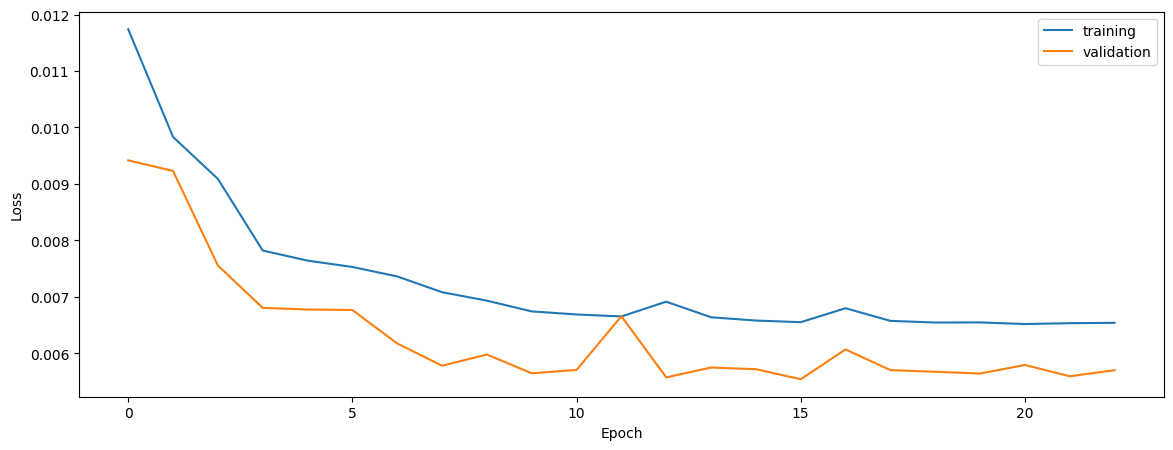

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.5830524569799785
0.6490128569011498
0.5969967472351256


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.5830524569799785
0.6490128569011498
0.5969967472351256


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.5934148572275211
0.6563757833840226
0.6135631876828227


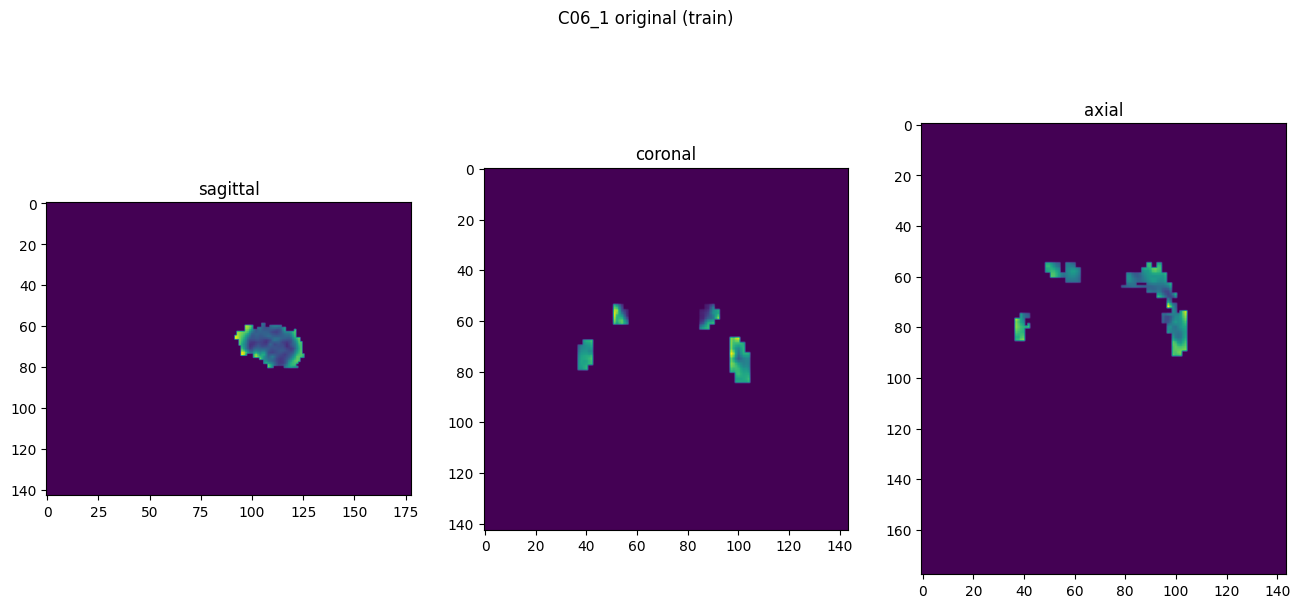

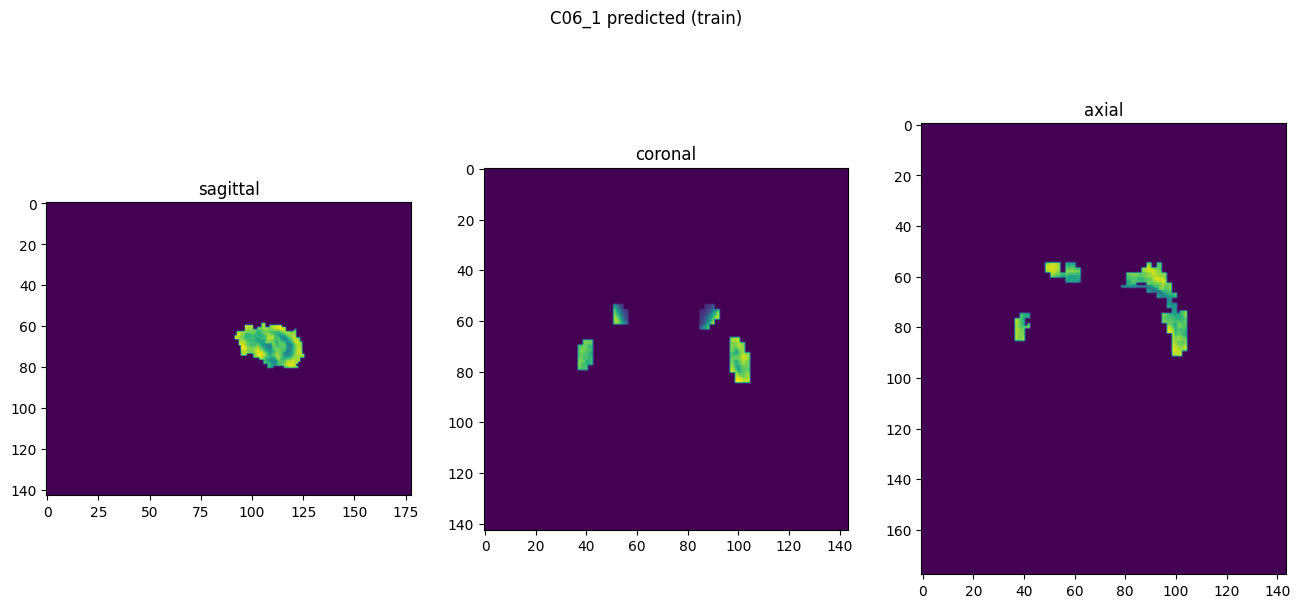

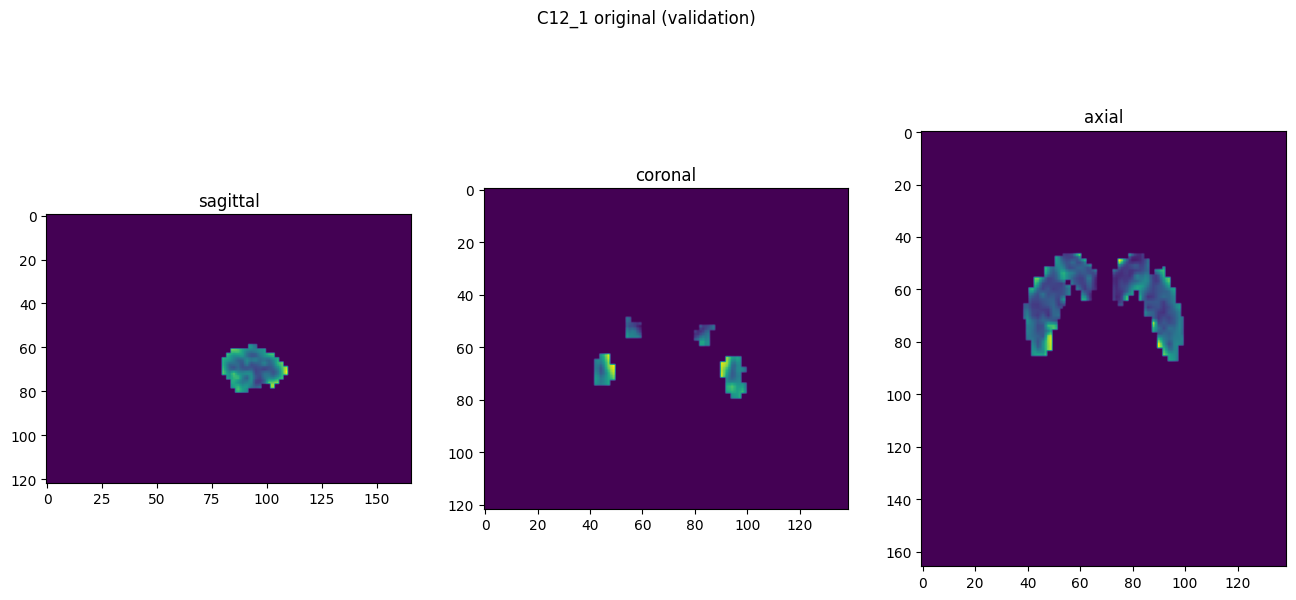

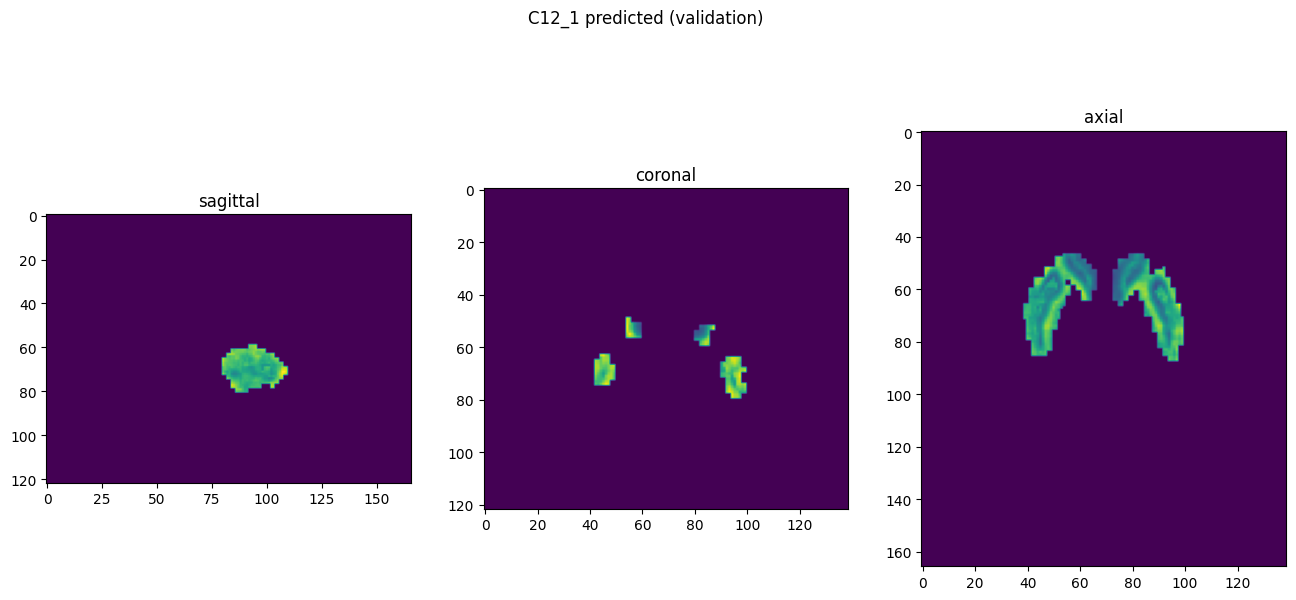

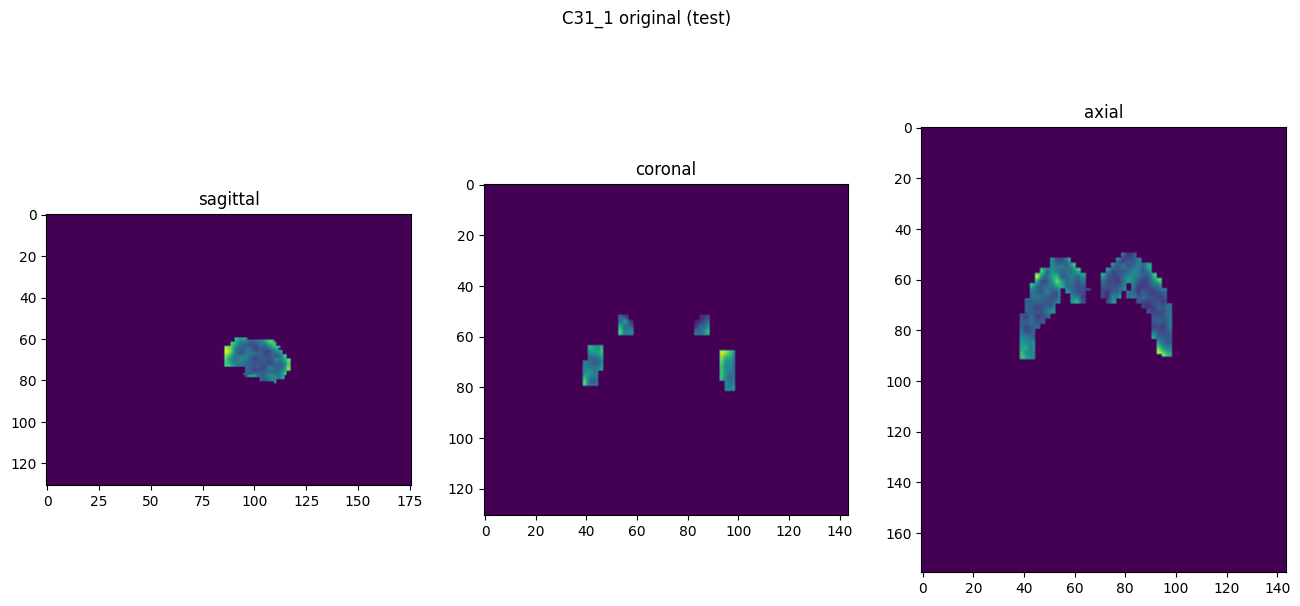

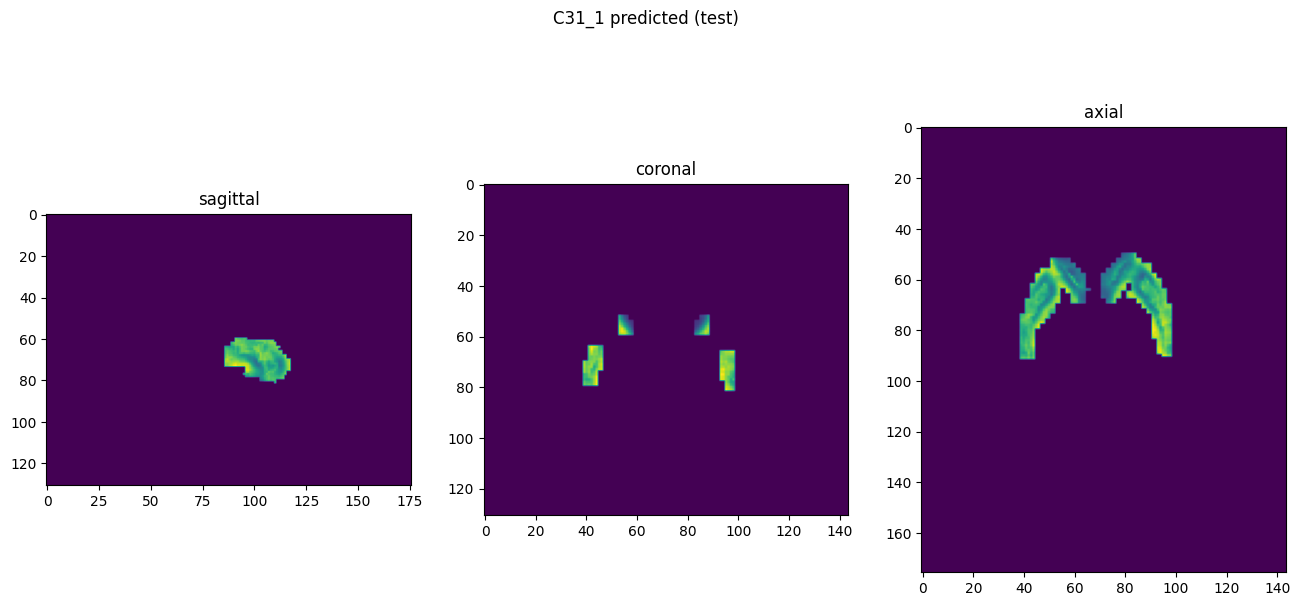

In [10]:
showResults(model, gen, threshold=None, background=False)